# European options dynamics and the principles of hedging

In this notebook, we will study the dynamics of the European call/put options under delta hedging. For these simple derivatives, we know that the value of our portfolio denoted $X_{n}$ at timestep $n$ will evolve according to the update rule
\begin{equation}
    X_{n+1} = S_{n+1} \Delta_{n} + (1 + r) (X_{n} - S_{n}\Delta_{n})\,.
\end{equation}
This model is incredibly basic and straigtforward to understand. The first term describes the change in our hedge determined by changes in the value of the underlying asset. The second term describes our cash position which is invested in the money market, comprised of the our current wealth minus the value of stock that we held. For $n=0$, $X_{0}$ would correspond to our initial wealth---determined by the value of our derivative---and $\Delta_{0}S_{0}$ the amount of stock in our hedging portfolio. Now if $X_{0}-S_{0}\Delta_{0}<0$, then this means that our initial position is negative i.e we are in debt, that is we do not have enough initial wealth to finance the hedge, thus we must borrow it from the money market. At each time-step it inflates in value due to the interest rate $r$. Let's explore our our wealth changes for some under the asset pricing model.

In [708]:
import numpy as np
from functools import wraps
from time import time
from scipy.special import binom
import matplotlib.pyplot as plt
from Binomial_asset_tree import *

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style('grade3')

To start this off, let's consider a simple European call option reflecting our belief that some underlying asset priced at $S_{0}$ is going to increase in value. We can easily contruct such a model in which we expect the real asset price to rise over time. In this model, we expect the increase in the price of the underlying to correspond to an increase in our overall wealth

In [894]:
# Days to expirey 
T = 20
# Number of time steps
N = 100
# Number of hedges a day
h = N/T
# up factor per day
u_per_day = 1.1
# up factor per hedge 
u = u_per_day**(1/h)
# probability of up move per day
p_per_day = 0.5
# probability of up move per hedge
p = (p_per_day)
# Strike price
K = 90
# Initial asset price
S0 = 100
r = 0.01

# Create params dictionary
params = {'S0': S0,
            'r': r,
            'u': u,
            'K': K,
            'N': N,
            'T': T,
            'option': 'call'}

# create random model
# m_call = binomial_tree_european(params)
m_call = EuropeanBAT(**params)

# Real asset price increases by 
print('S1/(1 +r) =', (u*S0 * p + (1-p)*(1/u)*S0))
print("Price of initial option =", m_call.initial_option_price[0])
print("Initial hedging ratio =", m_call.initial_hedge[0])
print("Initial stock price * delta0 =", m_call.initial_hedge[0]*m_call.S0)
print(p)

S1/(1 +r) = 100.01816861088605
Price of initial option = 3.944988261897498
Initial hedging ratio = 0.34583572107422134
Initial stock price * delta0 = 34.583572107422135
0.5


Let's now simulate this over 1000 trajectories and compute the averages. Here we will define a useful function

In [895]:
def compute_trajectories(model, ntraj):
    # Evolve to last step 
    n = model.N - 1

    # Create a random list of list of ups and downs with real probabilities
    # np.random.seed(4)
    traj = np.random.choice([1,0], size=(n-1, ntraj), p=[p, 1-p])

    # Initialize arrays 
    Xn = np.zeros((n, ntraj))
    dn = np.zeros((n, ntraj))
    Sn = np.zeros((n, ntraj))

    # Set our initial wealth = option price and initial hedge ratio
    Xn[0, :] = 100 - model.initial_option_price 
    dn[0, :] = model.initial_hedge
    Sn[0, :] = model.S0

    # Create iterating index to track number of ups vs downs
    vi = np.zeros(ntraj, dtype=int)

    for i, v in enumerate(traj):

        # Keep a tally of 1's correspond to total number of H
        vi += v

        # Now the only pain in the ass is that we need to compute all the dn's
        Sn[i+1, :] = Sn[i] * (model.u)**(v) * (model.d)**(1-v)      # use reall probabilities
        Xn[i+1, :] = dn[i, :] * Sn[i+1, :] + model.disc * (Xn[i, :] -  dn[i, :] * Sn[i, :])
        dn[i+1, :] = model.hedging_ratio(i+1)[vi]
        
    return Xn, Sn, dn

In [896]:
# Number of trajectories 
ntraj = 10000

# Compute trajectories
Xn, Sn, dn = compute_trajectories(m_call, ntraj)

# Compute in real terms by discounting interest rates
Xn_real = (Xn.T/(m_call.disc**np.arange(N-1))).T
Sn_real = (Sn.T/(m_call.disc**np.arange(N-1))).T
cash_real = Xn_real - dn*Sn_real

# Compute mean over all trajectries
Xn_mean = np.mean(Xn_real, axis=1)
Sn_mean= np.mean(Sn_real, axis=1)
dn_mean = np.mean(dn, axis=1)
cash_mean = Xn_mean - dn_mean*Sn_mean

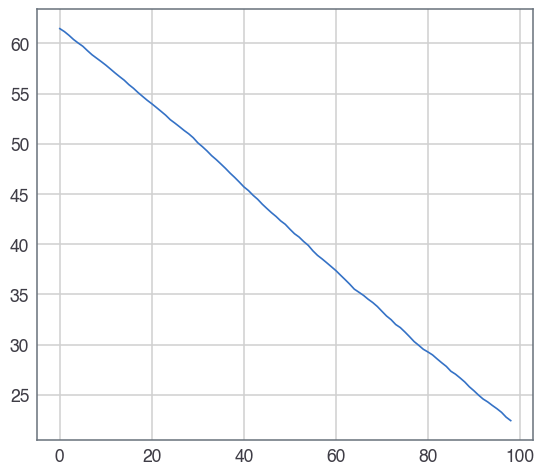

In [897]:
plt.plot(cash_mean)

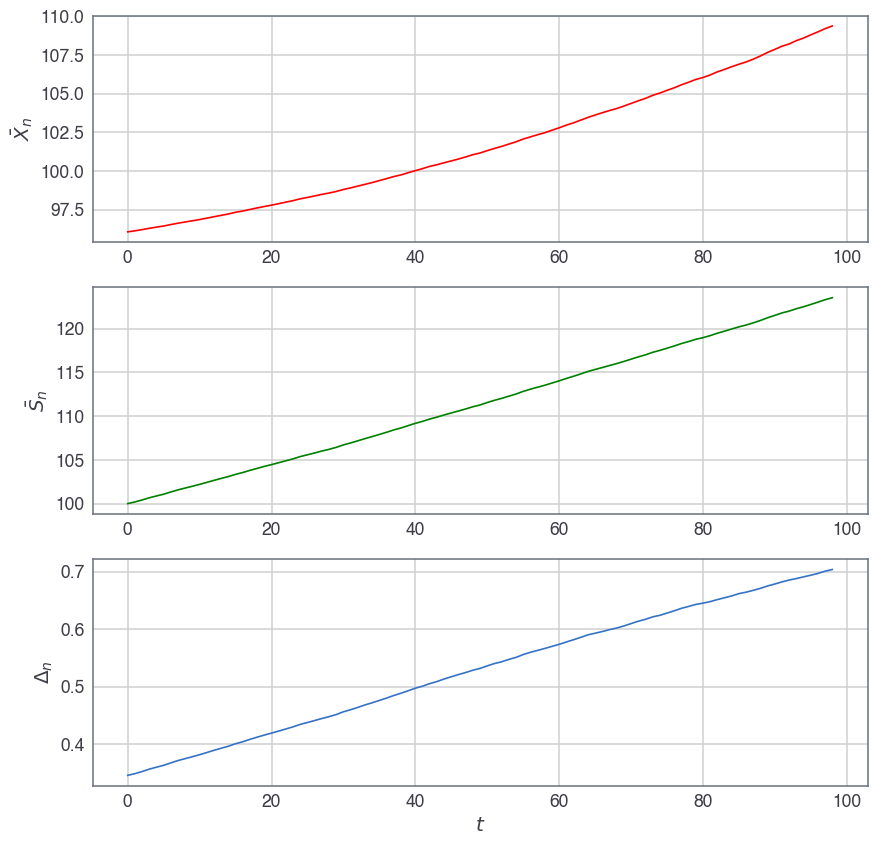

In [898]:
fig = plt.figure(figsize=(10, 10))

# Create plots 
plt.subplot(3, 1, 1)
plt.plot(Xn_mean , color='red')
plt.ylabel(r'$\bar{X}_{n}$')
plt.subplot(3, 1, 2)
plt.plot(Sn_mean , color='green')
plt.ylabel(r'$\bar{S}_{n}$')
plt.subplot(3, 1, 3)
plt.plot(dn_mean , color='b')
plt.ylabel(r'$\Delta_{n}$')
plt.xlabel(r'$t$')

plt.show()

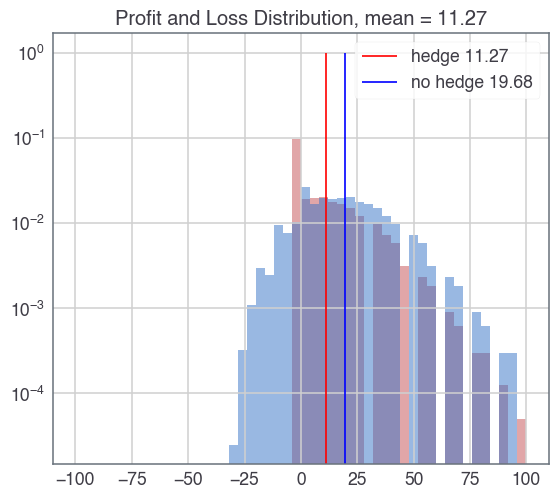

In [899]:
# Compute profit/loss
pandL_hedge = Xn[-1,:] - Xn[0,:]*(m_call.disc**N)
mean_pandL = np.mean(pandL_hedge) 

# no hedge, just go and buy the underlying 
pandL_no_hedge = (Sn[-1, :] - Sn[0, :]*(m_call.disc**N))
mean_pandL_no_hedge = np.mean(pandL_no_hedge)

plt.hist(pandL_hedge, bins=50, density=True, alpha=0.5, color='r', range=[-100, 100])
plt.hist(pandL_no_hedge, bins=50, density=True, alpha=0.5, color='b', range=[-100, 100])
plt.vlines(mean_pandL, 0, 1, color='red', label='hedge ' + str(np.round(mean_pandL, 2)))
plt.vlines(mean_pandL_no_hedge, 0, 1, color='blue', label='no hedge '+ str(np.round(mean_pandL_no_hedge, 2)))
plt.title('Profit and Loss Distribution, mean = ' + str(np.round(mean_pandL, 2)))

plt.legend(loc='upper right')
# plt.ylim([0, 0.1])

plt.yscale('log')
plt.show()

We can clearly see that as the stock rises, so too does our average wealth and vice versa. This tells us that the a call option is has a positive correlation with the market. Moreover, if we plot our cash position as a function of time (bottom) we can clearly see that the initial money we borrowed from the money market becomes positive reflecting the fact that we are decreasing hedge and paying down any debt. 
Furthermore, we can see what what our profit and loss is if we hedge our position, vs if we simply buy the underlying. Clearly, we can see that our potential upside from the no hedge is much larger, but so too is our downside. If we purchase an option, and then hedge using the delta hedging approach, we can protect ourselves from the downside risk. At the end of the day, all we will loose is that initial price + premium of the option purchase. So in short, we protect ourselves from the downside, but keep a substaintial upside. 

# For a put option, we expect the opposite behaviour

Let's assume here that we made a bad bet. Recall that for a put option, we are taking a bearish position on the market and we expect it to go down. All we will do simply change our option to a put and repeat the calculation of the trajectories

In [501]:
# Create params dictionary
params['option'] = 'put'

# create random model
m_put = EuropeanBAT(**params)

In [502]:
# Number of trajectories 
ntraj = 10000

# Compute trajectories
Xn, Sn, dn = compute_trajectories(m_put, ntraj)

# Compute in real terms by discounting interest rates
Xn_real = (Xn.T/(m_put.disc**np.arange(N-1))).T
Sn_real = (Sn.T/(m_put.disc**np.arange(N-1))).T

# Compute mean over all trajectries
Xn_mean = np.mean(Xn_real, axis=1)
Sn_mean= np.mean(Sn_real, axis=1)
dn_mean = np.mean(dn, axis=1)

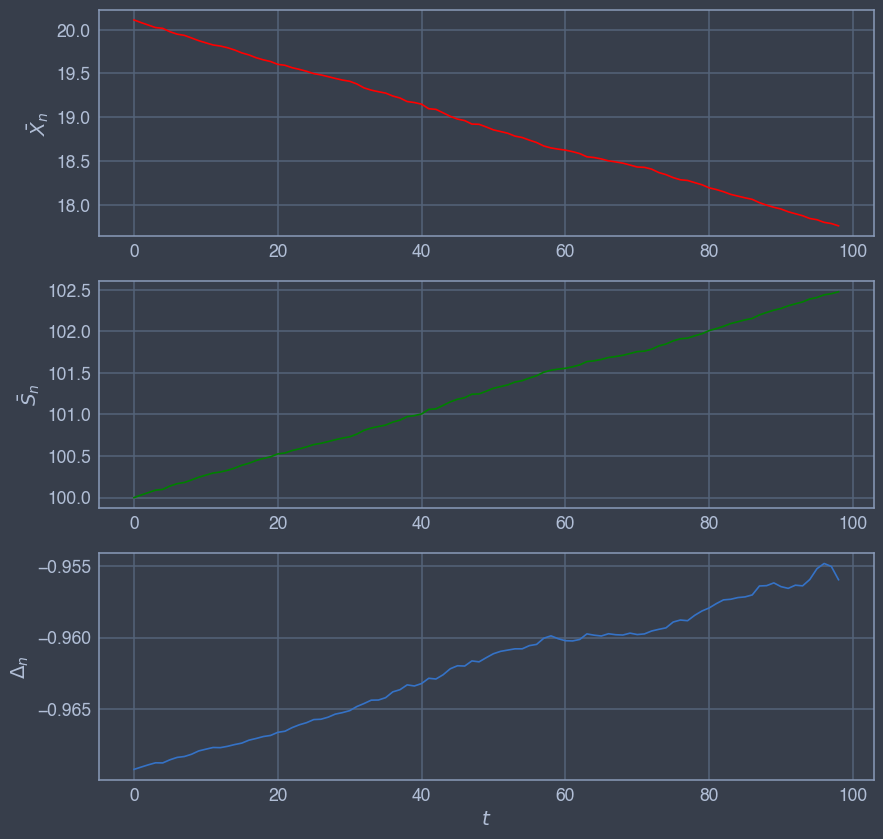

In [503]:
fig = plt.figure(figsize=(10, 10))

# Create plots 
plt.subplot(3, 1, 1)
plt.plot(Xn_mean , color='red')
plt.ylabel(r'$\bar{X}_{n}$')
plt.subplot(3, 1, 2)
plt.plot(Sn_mean , color='green')
plt.ylabel(r'$\bar{S}_{n}$')
plt.subplot(3, 1, 3)
plt.plot(dn_mean , color='b')
plt.ylabel(r'$\Delta_{n}$')
plt.xlabel(r'$t$')

plt.show()

We can clearly see that our wealth is anti-correlated with the stock price (that is when it rises, our wealth goes down and vice versa). 